# ALS Implementation on implicit feedback

This notebook uses ratings.csv from [Movielens](https://grouplens.org/datasets/movielens/latest/) to implement ALS developed in this [paper](http://yifanhu.net/PUB/cf.pdf)  


In [81]:
# Import the required library
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm_notebook

### Reading in ratings data

ratings = pd.read_csv('/Users/Kirsteenng_1/Data Science/Movie Recommendation system/ratings.csv')

In [13]:
ratings.describe

<bound method NDFrame.describe of         userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]>

In [21]:
ratings = ratings.drop('timestamp',axis = 1)
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


### Creating a rating matrix of userId x movieId by pivot_table()

In [18]:
rating_mat = ratings.pivot_table('rating', 'userId', 'movieId', fill_value=0)
rating_mat

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0,0.0,4.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0


### From here we can see that there are a total of 610 users and 9724 movies.  We will denote the following variables   
Nu = number of users  
Nm = number of movies  
Nl = dimension of the latent vector

In [25]:
Nu = rating_mat.shape[0]
Nm = rating_mat.shape[1]


(610, 9724)

## Parameters initialization
###  We need to initialise the parameters lambda, alpha and Nf, the dimension of the latent variable. The following values provide the best performance according to the [paper](http://yifanhu.net/PUB/cf.pdf).  
- r_lambda: normalization parameter  
- alpha: confidence level  
- Nf: dimension of latent vector of each user and item


In [26]:
r_lambda = 20
alpha = 400
Nf = 20

### Then we need to create user matrix, U, and movie matrix, M. 

In [28]:
U = np.random.rand(Nu, Nf) * 0.01
M = np.random.rand(Nm, Nf) * 0.01
M

array([[8.73167437e-05, 9.05098799e-04, 3.49924608e-03, ...,
        3.52853167e-03, 4.05581064e-03, 4.94824755e-03],
       [1.06876739e-03, 3.12310629e-03, 2.45591761e-03, ...,
        6.75319748e-03, 3.67604183e-04, 3.87114192e-03],
       [4.23557439e-03, 2.71441566e-04, 3.79654283e-03, ...,
        3.26058652e-03, 1.45376996e-03, 2.48833355e-03],
       ...,
       [8.06994925e-03, 4.22222376e-03, 4.09095877e-05, ...,
        7.55900963e-04, 6.81093963e-03, 2.84016555e-03],
       [8.72491526e-03, 5.89377868e-03, 9.76836141e-03, ...,
        7.88521344e-03, 6.49410766e-03, 4.33512535e-03],
       [6.90023043e-03, 1.80611820e-03, 7.81477563e-03, ...,
        9.97662760e-03, 7.75733075e-03, 6.83790239e-03]])

### Initialize binary matrix, P, from rating matrix  
The binary matrix, P, represent the information that whether the user i like movie j if rating_mat[i,j] > 1.  
This is the part that provides the implicit feedback.  

P[i,j] = 1 if rating_mat > 0  
P[i,j] = 0 if rating_mat = 0   

In [30]:
P = np.copy(rating_mat)
P[P > 0] = 1
P

array([[1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

### Initialize confidence matrix, C
The confidence matrix, C, measures the confidence in observing p[i,j].   
Each entry of C is defined below  
C[i,j] = 1 + alpha* rating_mat[i,j]

In [73]:
C = 1 + alpha * rating_mat
C = C.to_numpy()
C

array([[1.601e+03, 1.000e+00, 1.601e+03, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       [1.000e+00, 1.000e+00, 1.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       [1.000e+00, 1.000e+00, 1.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       ...,
       [1.001e+03, 8.010e+02, 8.010e+02, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       [1.201e+03, 1.000e+00, 1.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       [2.001e+03, 1.000e+00, 1.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00]])

### Constructing loss function
Remember that the loss function that we are trying to minimize comes in two parts, the prediction loss and the regularization loss. Here we will define the loss function.  

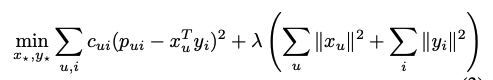

- P : binary rating matrix
- X : user latent matrix
- Y : movie latent matrix
- C : confidence matrix
- xTy : prediction matrix 



In [54]:
def loss_func(P,xTy,X,Y,C,r_lambda):
    prediction_loss = np.square(P - xTy)
    confidence_loss = np.sum(C * prediction_loss)
    regularization_loss = r_lambda * (np.sum(np.square(X)) + np.sum(np.square(Y)))
    total_loss = confidence_loss + regularization_loss
    return np.sum(prediction_loss), confidence_loss.astype(float), regularization_loss ,total_loss

### Optimization function for user and movie
X[u] = (yTCuy + lambda*I)^-1yTCuy  
Y[i] = (xTCix + lambda*I)^-1xTCix  
The above formulas are the
two formula is the same when it changes X to Y and u to i  

In [82]:
def optimize_user(X, Y, C, P, Nu, Nf, r_lambda):
    yT = np.transpose(Y)
    for u in tqdm_notebook(range(Nu),desc = 'Optimizing User Matrix'):
        Cu = np.diag(C[u])
        yT_Cu_y = np.matmul(np.matmul(yT, Cu), Y)
        lI = np.dot(r_lambda, np.identity(Nf))
        yT_Cu_pu = np.matmul(np.matmul(yT, Cu), P[u])
        X[u] = np.linalg.solve(yT_Cu_y + lI, yT_Cu_pu)

def optimize_movie(X, Y, C, P, Nm, Nf, r_lambda):
    xT = np.transpose(X)
    for i in tqdm_notebook(range(Nm), desc = 'Optimizing Movie Matrix'):
        Ci = np.diag(C[:, i])
        xT_Ci_x = np.matmul(np.matmul(xT, Ci), X)
        lI = np.dot(r_lambda, np.identity(Nf))
        xT_Ci_pi = np.matmul(np.matmul(xT, Ci), P[:, i])
        Y[i] = np.linalg.solve(xT_Ci_x + lI, xT_Ci_pi)

In [85]:
predict_errors = []
confidence_errors = []
regularization_list = []
total_losses = []

for i in tqdm_notebook(range(15), desc = 'Main training Loop'):
    if i!=0:   
        optimize_user(U, M, C, P, Nu, Nf, r_lambda)
        optimize_movie(U, M, C, P, Nm, Nf, r_lambda)
    predict = np.matmul(U, np.transpose(M))
    predict_error, confidence_error, regularization, total_loss = loss_func(P, predict, U, M,C, r_lambda)
    
    predict_errors.append(predict_error)
    confidence_errors.append(confidence_error)
    regularization_list.append(regularization)
    total_losses.append(total_loss)
    
    print('----------------step %d----------------' % i)
    print("predict error: %f" % predict_error)
    print("confidence error: {}".format(confidence_error))
    print("regularization: %f" % regularization)
    print("total loss: %f" % total_loss)
    
predict = np.matmul(U, np.transpose(M))
print('final predict')
print([predict])

Main training Loop:   0%|          | 0/15 [00:00<?, ?it/s]

----------------step 0----------------
predict error: 2777823.220202
confidence error: 10373023.895312458
regularization: 11610049.806053
total loss: 21983073.701365


Optimizing User Matrix:   0%|          | 0/610 [00:00<?, ?it/s]

Optimizing Movie Matrix:   0%|          | 0/9724 [00:00<?, ?it/s]

----------------step 1----------------
predict error: 1151810.554899
confidence error: 2146512.086479279
regularization: 11660498.790241
total loss: 13807010.876720


Optimizing User Matrix:   0%|          | 0/610 [00:00<?, ?it/s]

Optimizing Movie Matrix:   0%|          | 0/9724 [00:00<?, ?it/s]

----------------step 2----------------
predict error: 948917.748956
confidence error: 1466285.6476057542
regularization: 5590846.049858
total loss: 7057131.697464


Optimizing User Matrix:   0%|          | 0/610 [00:00<?, ?it/s]

Optimizing Movie Matrix:   0%|          | 0/9724 [00:00<?, ?it/s]

----------------step 3----------------
predict error: 844500.172392
confidence error: 1092062.2151374551
regularization: 2656319.139949
total loss: 3748381.355086


Optimizing User Matrix:   0%|          | 0/610 [00:00<?, ?it/s]

Optimizing Movie Matrix:   0%|          | 0/9724 [00:00<?, ?it/s]

----------------step 4----------------
predict error: 791716.638324
confidence error: 935078.6876059474
regularization: 1469819.883465
total loss: 2404898.571071


Optimizing User Matrix:   0%|          | 0/610 [00:00<?, ?it/s]

Optimizing Movie Matrix:   0%|          | 0/9724 [00:00<?, ?it/s]

----------------step 5----------------
predict error: 766100.246039
confidence error: 871172.1954796556
regularization: 1034217.805063
total loss: 1905390.000542


Optimizing User Matrix:   0%|          | 0/610 [00:00<?, ?it/s]

Optimizing Movie Matrix:   0%|          | 0/9724 [00:00<?, ?it/s]

----------------step 6----------------
predict error: 749322.977928
confidence error: 838726.4594591301
regularization: 852831.544282
total loss: 1691558.003741


Optimizing User Matrix:   0%|          | 0/610 [00:00<?, ?it/s]

Optimizing Movie Matrix:   0%|          | 0/9724 [00:00<?, ?it/s]

----------------step 7----------------
predict error: 736013.809100
confidence error: 817611.4585345566
regularization: 758908.422023
total loss: 1576519.880557


Optimizing User Matrix:   0%|          | 0/610 [00:00<?, ?it/s]

Optimizing Movie Matrix:   0%|          | 0/9724 [00:00<?, ?it/s]

----------------step 8----------------
predict error: 724898.697325
confidence error: 801697.2598911896
regularization: 700242.042086
total loss: 1501939.301977


Optimizing User Matrix:   0%|          | 0/610 [00:00<?, ?it/s]

Optimizing Movie Matrix:   0%|          | 0/9724 [00:00<?, ?it/s]

----------------step 9----------------
predict error: 715484.232207
confidence error: 788874.556920092
regularization: 658766.677990
total loss: 1447641.234910


Optimizing User Matrix:   0%|          | 0/610 [00:00<?, ?it/s]

Optimizing Movie Matrix:   0%|          | 0/9724 [00:00<?, ?it/s]

----------------step 10----------------
predict error: 707450.340453
confidence error: 778191.3280633395
regularization: 627190.971678
total loss: 1405382.299741


Optimizing User Matrix:   0%|          | 0/610 [00:00<?, ?it/s]

Optimizing Movie Matrix:   0%|          | 0/9724 [00:00<?, ?it/s]

----------------step 11----------------
predict error: 700561.138718
confidence error: 769116.1859541
regularization: 602011.516400
total loss: 1371127.702354


Optimizing User Matrix:   0%|          | 0/610 [00:00<?, ?it/s]

Optimizing Movie Matrix:   0%|          | 0/9724 [00:00<?, ?it/s]

----------------step 12----------------
predict error: 694618.132250
confidence error: 761305.2121927912
regularization: 581268.610669
total loss: 1342573.822862


Optimizing User Matrix:   0%|          | 0/610 [00:00<?, ?it/s]

Optimizing Movie Matrix:   0%|          | 0/9724 [00:00<?, ?it/s]

----------------step 13----------------
predict error: 689443.180872
confidence error: 754502.381971125
regularization: 563748.154931
total loss: 1318250.536902


Optimizing User Matrix:   0%|          | 0/610 [00:00<?, ?it/s]

Optimizing Movie Matrix:   0%|          | 0/9724 [00:00<?, ?it/s]

----------------step 14----------------
predict error: 684886.166343
confidence error: 748507.3427055132
regularization: 548648.094251
total loss: 1297155.436956
final predict
[array([[ 1.00303829,  0.99556943,  0.98381099, ..., -0.12938931,
        -0.12938931, -0.16904929],
       [ 0.95704142,  0.92985785,  0.77295637, ...,  0.1631968 ,
         0.1631968 ,  0.33612004],
       [ 0.92040273,  0.89777733,  0.90727972, ..., -0.00277233,
        -0.00277233, -0.1396807 ],
       ...,
       [ 1.00523487,  1.01564844,  1.02561738, ..., -0.24587623,
        -0.24587623,  0.00936036],
       [ 0.99829668,  0.9751186 ,  0.96286047, ..., -0.22397197,
        -0.22397197, -0.13391347],
       [ 0.99146173,  0.98954438,  0.78465447, ..., -0.02291399,
        -0.02291399, -0.41010574]])]


<Figure size 432x288 with 0 Axes>

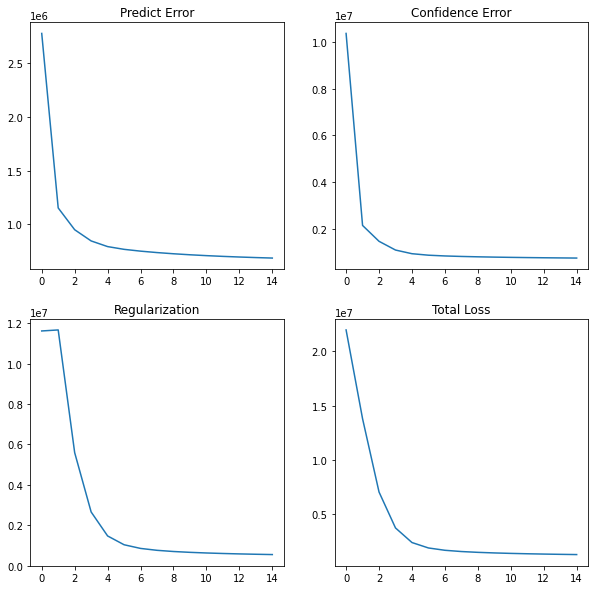

In [86]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.subplots_adjust(wspace=100.0, hspace=20.0)
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
predict_error_line = fig.add_subplot(2, 2, 1)
confidence_error_line = fig.add_subplot(2, 2, 2)
regularization_error_line = fig.add_subplot(2, 2, 3)
total_loss_line = fig.add_subplot(2, 2, 4)

predict_error_line.set_title("Predict Error") 
predict_error_line.plot(predict_errors)

confidence_error_line.set_title("Confidence Error")
confidence_error_line.plot(confidence_errors)

regularization_error_line.set_title("Regularization")
regularization_error_line.plot(regularization_list)

total_loss_line.set_title("Total Loss")
total_loss_line.plot(total_losses)
plt.show()